# 헤더

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install music21

In [ ]:
!pip install midi2audio

In [ ]:
!pip install midiutil

In [ ]:
!pip install mido

In [6]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
from music21 import converter, note, stream, environment
from midi2audio import FluidSynth
from midiutil import MIDIFile

#계이름 주파수 도메인 정의

In [7]:
# hertz2keys 데이터프레임 정의
hertz2keys = pd.DataFrame({
    'A': [27.50, 55.00, 110.00, 220.00, 440.00, 880.00, 1760.00, 3520.00, 7040.00],
    'B': [30.87, 61.74, 123.47, 246.94, 493.88, 987.77, 1975.53, 3951.07, 7902.13],
    'Bb': [29.14, 58.27, 116.54, 233.08, 466.16, 932.33, 1864.66, 3729.31, 7458.62],
    'C': [16.35, 32.70, 65.41, 130.81, 261.63, 523.25, 1046.50, 2093.00, 4186.01],
    'C#': [17.32, 34.65, 69.30, 138.59, 277.18, 554.37, 1108.73, 2217.46, 4434.92],
    'D': [18.35, 36.71, 73.42, 146.83, 293.66, 587.33, 1174.66, 2349.32, 4698.64],
    'D#': [19.45, 38.89, 77.78, 155.56, 311.13, 622.25, 1244.51, 2489.02, 4978.03],
    'E': [20.60, 41.20, 82.41, 164.81, 329.63, 659.26, 1318.51, 2637.02, 5274.04],
    'F': [21.83, 43.65, 87.31, 174.61, 349.23, 698.46, 1396.91, 2793.83, 5587.65],
    'F#': [23.12, 46.25, 92.50, 185.00, 369.99, 739.99, 1479.98, 2959.96, 5919.91],
    'G': [24.50, 49.00, 98.00, 196.00, 392.00, 783.99, 1567.98, 3135.96, 6271.93],
    'G#': [25.96, 51.91, 103.83, 207.65, 415.30, 830.61, 1661.22, 3322.44, 6644.88]
}, index=['0', '1', '2', '3', '4', '5', '6', '7', '8'])

#오디오 불러오기
slice_duration = 0.01~0.2 추천

In [9]:
# 오디오 파일 경로
audio_path = '/content/drive/MyDrive/audio_study/test.mp3'

# 오디오 불러오기
y, sr = librosa.load(audio_path, sr=None)

# 슬라이싱 간격 설정 (0.01초)
slice_duration = 0.05
slice_samples = int(slice_duration * sr)

# FFT를 위한 윈도우 크기 설정
n_fft = 2048

# 결과를 저장할 데이터프레임 생성
result_df = pd.DataFrame(columns=['start_time', 'end_time', 'key'])

In [10]:
for i in range(0, len(y), slice_samples):
    # 슬라이싱된 오디오 데이터
    audio_slice = y[i:i+slice_samples]

    # FFT 적용
    spectrum = np.abs(librosa.stft(audio_slice, n_fft=n_fft))

    # 슬라이싱된 부분에서 주파수가 가장 큰 부분 추출
    max_freq_index = np.argmax(np.sum(spectrum, axis=1))

    # 주파수가 0이 아니라면 처리
    if max_freq_index > 0:
        # 해당 주파수에 대응되는 계이름 찾기
        hz = max_freq_index * sr / n_fft

        # 주파수에 대응되는 키 찾기
        key = None
        min_diff = float('inf')
        for column in hertz2keys.columns:
            diff = np.abs(hz - hertz2keys[column].values)
            min_index = np.argmin(diff)

            if diff[min_index] < min_diff:
                min_diff = diff[min_index]
                key = f'{column}{hertz2keys.index[min_index]}'

        # 결과 데이터프레임에 추가
        result_df = pd.concat([result_df, pd.DataFrame({
            'start_time': [i / sr],
            'end_time': [(i + slice_samples) / sr],
            'key': [key] if key else ['Unknown']
        })], ignore_index=True)
    else:
        # 주파수가 0인 경우 'Unknown'으로 처리
        result_df = pd.concat([result_df, pd.DataFrame({
            'start_time': [i / sr],
            'end_time': [(i + slice_samples) / sr],
            'key': ['Unknown']
        })], ignore_index=True)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1274
  warnings.warn(


In [11]:
result_df

,start_time,end_time,key
0,0.00,0.05,B8
1,0.05,0.10,F5
2,0.10,0.15,C#8
3,0.15,0.20,D8
4,0.20,0.25,B8
...,...,...,...
314,15.70,15.75,C5
315,15.75,15.80,C5
316,15.80,15.85,C5
317,15.85,15.90,D#5


#자른 음표 다시 합치기

In [12]:
threshold = 0.25

combined_df = pd.DataFrame(columns=['start_time', 'end_time', 'key'])

# 초기 값 설정
current_start_time = result_df.loc[0, 'start_time']
current_end_time = result_df.loc[0, 'end_time']
current_key = result_df.loc[0, 'key']

# 계이름 추출할때 연속으로 같은음이 나오면 같은 박으로 합치기
for index, row in result_df.iloc[1:].iterrows():
    if row['start_time'] - current_end_time <= threshold and row['key'] == current_key:
        # 현재 음표를 연장
        current_end_time = row['end_time']
    else:
        # 새로운 음표 시작
        combined_df = pd.concat([combined_df, pd.DataFrame({
            'start_time': [current_start_time],
            'end_time': [current_end_time],
            'key': [current_key]
        })], ignore_index=True)

        # 초기 값 갱신
        current_start_time = row['start_time']
        current_end_time = row['end_time']
        current_key = row['key']

# 마지막 음표 추가
combined_df = pd.concat([combined_df, pd.DataFrame({
    'start_time': [current_start_time],
    'end_time': [current_end_time],
    'key': [current_key]
})], ignore_index=True)

In [13]:
combined_df

,start_time,end_time,key
0,0.00,0.05,B8
1,0.05,0.10,F5
2,0.10,0.15,C#8
3,0.15,0.20,D8
4,0.20,0.30,B8
5,0.30,0.35,C#7
6,0.35,0.40,G#6
7,0.40,0.45,A7
8,0.45,0.50,B8
9,0.50,0.55,F#7


#미디 파일 설정

In [14]:
# MIDI 파일 생성을 위한 설정
midi_stream = stream.Stream()
midi_stream.append(note.Rest())  # 아무 소리도 나지 않는 레스트 추가

# 키에 따라 MIDI 이벤트 추가
for index, row in combined_df.iterrows():
    key = row['key']

    # 'Unknown' 값이 아닌 경우에만 MIDI 노트 이벤트 추가
    if key != 'Unknown':
        start_time = row['start_time']
        end_time = row['end_time']

        # MIDI 노트 이벤트 추가
        midi_stream.append(note.Note(key, quarterLength=end_time - start_time))

# MIDI 파일 저장
midi_stream.write('midi', fp='/content/drive/MyDrive/audio_study/test.mid')

'/content/drive/MyDrive/audio_study/test.mid'

In [15]:
from music21 import stream, note, instrument

# MIDI 파일 생성을 위한 설정
midi_stream = stream.Score()

# 스트림에 악기 추가 (예: 'Violin' 악기)
midi_stream.append(instrument.Violin())

# 처음에 레스트 추가
midi_stream.append(note.Rest(quarterLength=1.0))

# 키에 따라 MIDI 이벤트 추가
for index, row in combined_df.iterrows():
    key = row['key']

    # 'Unknown' 값이 아닌 경우에만 MIDI 노트 이벤트 추가
    if key != 'Unknown':
        start_time = row['start_time']
        end_time = row['end_time']

        # MIDI 노트 이벤트 추가
        n = note.Note(key, quarterLength=end_time - start_time)

        # 노트에 악기 설정
        n.instrument = instrument.Violin()  # 다른 악기로 변경 가능

        midi_stream.append(n)

# MIDI 파일 저장
midi_stream.write('midi', fp='/content/drive/MyDrive/audio_study/test.mid')


'/content/drive/MyDrive/audio_study/test.mid'

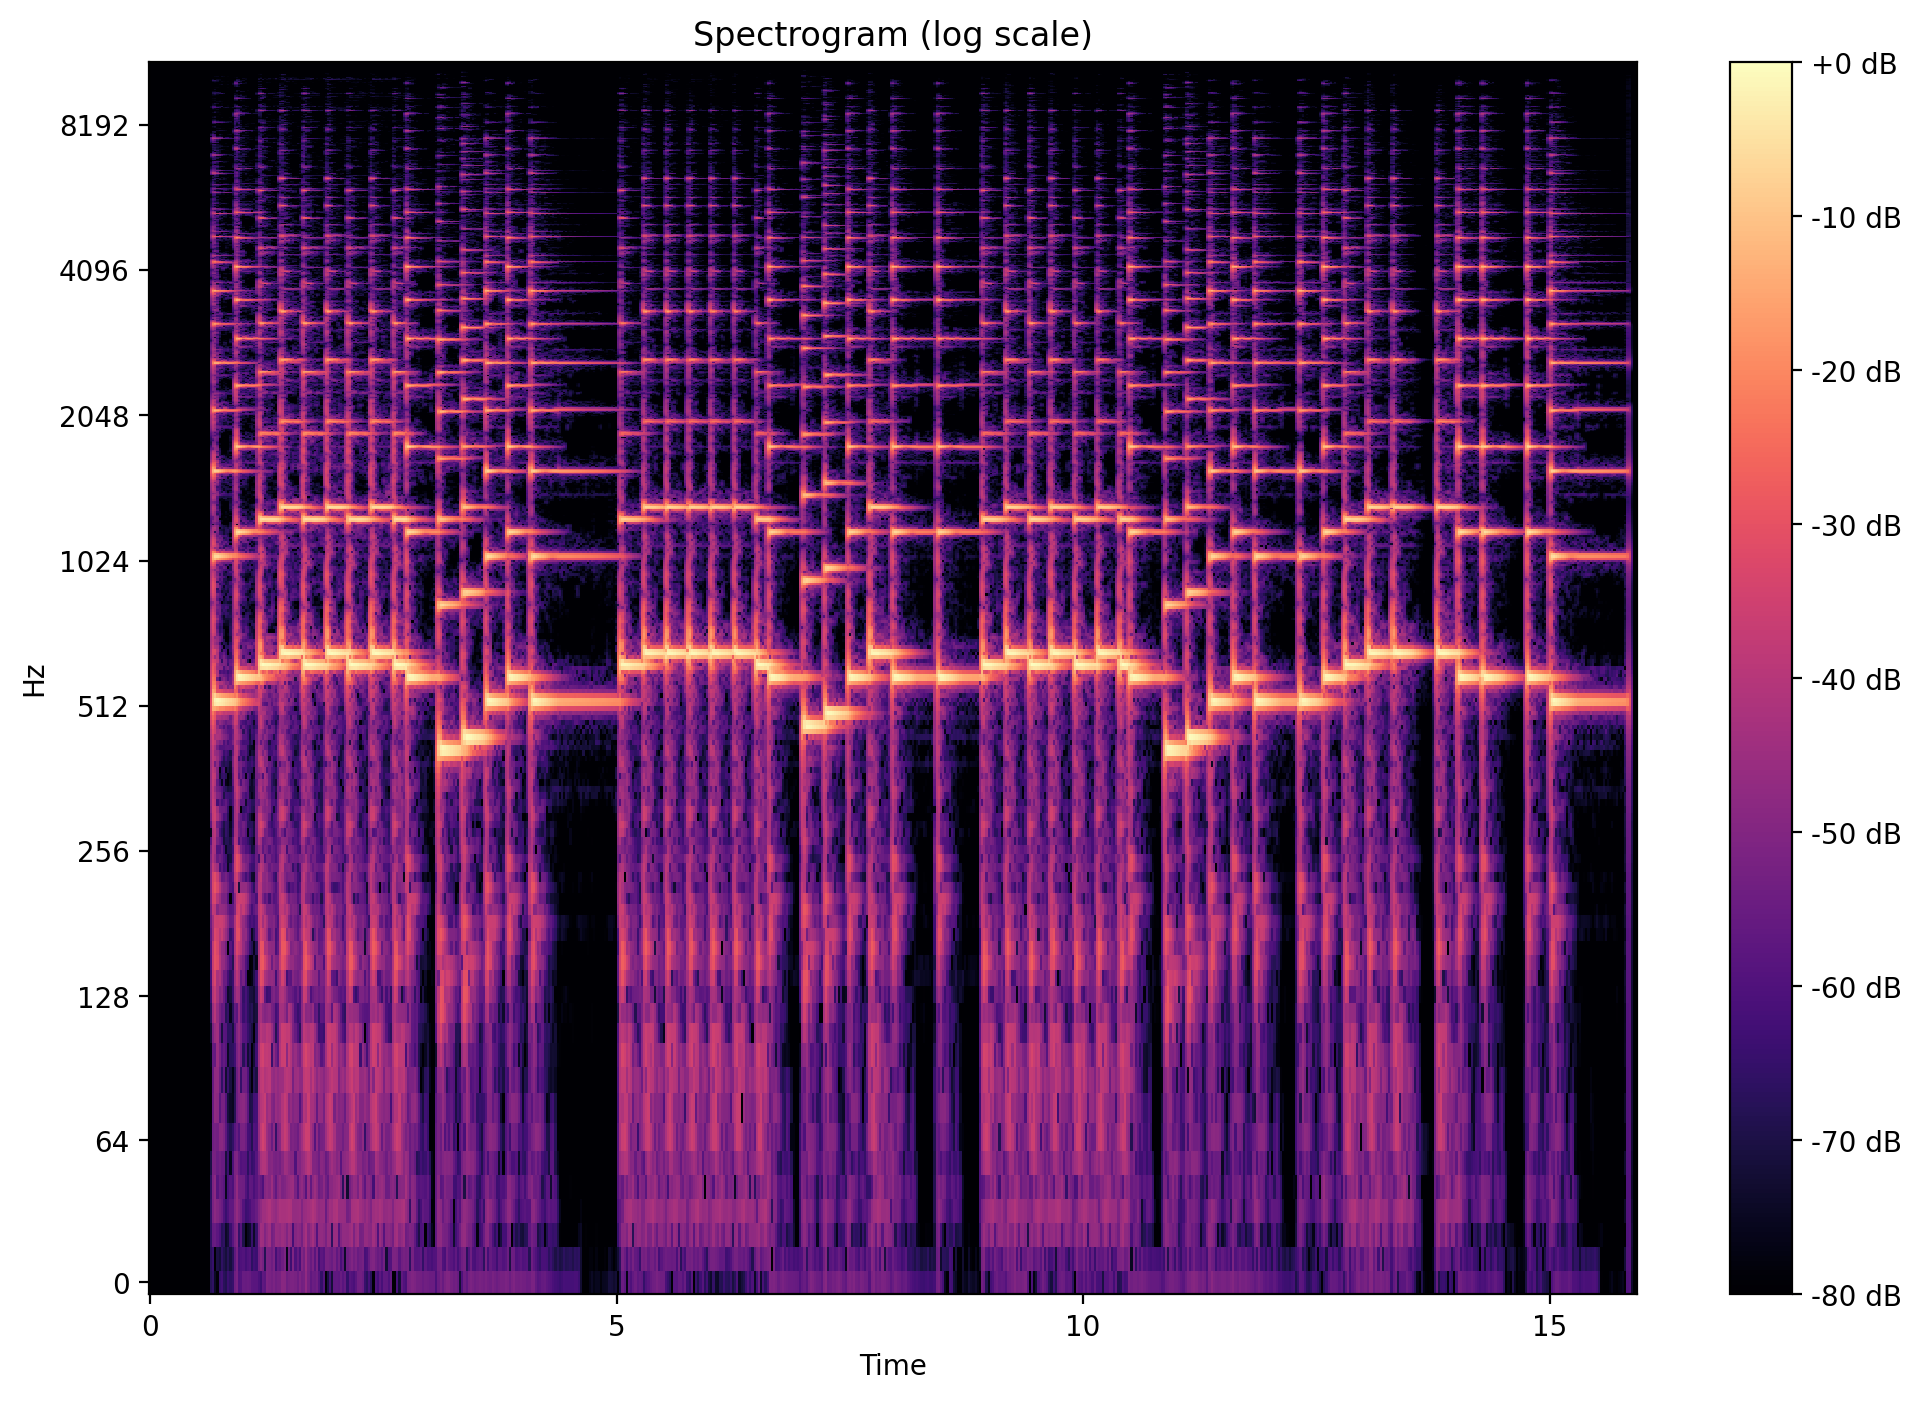

In [16]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 음원 파일 경로 설정
audio_file_path = '/content/drive/MyDrive/audio_study/test.mp3'

# librosa를 사용하여 음원을 로드
y, sr = librosa.load(audio_file_path)

# STFT 계산
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# 주파수 플롯 생성
plt.figure(figsize=(12, 8))

librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.title('Spectrogram (log scale)')
plt.show()


In [17]:
from music21 import *

# 노래 파일 불러오기 (예: MIDI 파일)
file_path = "/content/drive/MyDrive/audio_study/test.mid"
score = converter.parse(file_path)

# 악보의 모든 파트를 가져오기
for part in score.parts:
    print(f"Part: {part.id}")

    # 각 파트의 모든 음표를 가져와서 코드 확인
    for element in part.flat.notes:
        if isinstance(element, note.Note):
            print(f"Note: {element.nameWithOctave}, Offset: {element.offset}, Duration: {element.duration.quarterLength}, Chord: {element.isChord}")
        elif isinstance(element, chord.Chord):
            print(f"Chord: {element.pitchedCommonName}, Offset: {element.offset}, Duration: {element.duration.quarterLength}")


Part: 138083291591536
Chord: B-harmonic minor tetrachord, Offset: 1.0, Duration: 1/3
Chord: F#-dorian pentachord, Offset: 4/3, Duration: 0.25
Chord: Major 28th above C, Offset: 1.5, Duration: 0.25
Note: D5, Offset: 2.0, Duration: 0.25, Chord: False
Note: E-5, Offset: 2.25, Duration: 0.25, Chord: False
Note: E5, Offset: 7/3, Duration: 1/3, Chord: False
Note: E-5, Offset: 8/3, Duration: 1/3, Chord: False
Chord: Diminished Unison above Eb, Offset: 3.0, Duration: 1/3
Note: E5, Offset: 10/3, Duration: 1/3, Chord: False
Note: E-5, Offset: 11/3, Duration: 0.25, Chord: False
Note: D5, Offset: 3.75, Duration: 0.25, Chord: False
Note: G#4, Offset: 4.0, Duration: 1/3, Chord: False
Note: D5, Offset: 4.0, Duration: 1/12, Chord: False
Note: A4, Offset: 13/3, Duration: 1/3, Chord: False
Note: C5, Offset: 14/3, Duration: 0.25, Chord: False
Note: D5, Offset: 4.75, Duration: 0.25, Chord: False
Note: C5, Offset: 5.0, Duration: 1.0, Chord: False
Note: E-5, Offset: 6.0, Duration: 1/3, Chord: False
Note: E5

/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [18]:
from music21 import *

# 미디 파일 경로 설정
midi_file_path = '/content/drive/MyDrive/audio_study/test.mid'  # 미디 파일 경로로 변경해야 합니다.

# 미디 파일을 Music21 객체로 로드
score = converter.parse(midi_file_path)

# 각 파트의 마디를 반복하면서 코드를 확인
for part in score.parts:
    for measure in part.getElementsByClass(stream.Measure):
        # 마디의 코드를 추출
        chord_symbols = []
        for element in measure:
            if isinstance(element, chord.Chord):
                # Chord 객체에서 코드 추출
                chord_symbols.append(element.pitchedCommonName)

        # 마디의 코드 출력
        if chord_symbols:
            print(f"Measure {measure.number}: {' '.join(chord_symbols)}")
        else:
            print(f"Measure {measure.number}: No chords")


Measure 1: No chords
Measure 2: No chords
Measure 3: No chords
Measure 4: No chords
Measure 5: Major Second above Eb


In [19]:
from music21 import *

# 노래 파일 불러오기 (예: MIDI 파일)
file_path = "/content/drive/MyDrive/audio_study/test.mid"
score = converter.parse(file_path)

# 원하는 파트 선택
target_part_id = "your_target_part_id"  # 여기에 원하는 파트의 ID를 입력하세요

# 선택한 파트에서 마디별로 음표 확인
for part in score.parts:
    if part.id == target_part_id:
        measures = part.getElementsByClass(stream.Measure)
        for measure in measures:
            # 마디의 음표를 가져오기
            notes = measure.flat.notes

            # 음표들의 계이름을 추출하여 리스트에 저장
            pitches = [note.pitch.nameWithOctave for note in notes if isinstance(note, note.Note)]

            # 계이름으로 코드진행 판단
            chord_progression = harmony.chordSymbolFigureFromPitches(pitches)

            # 결과 출력
            print(f"Measure {measure.number}: Chord Progression - {chord_progression}")


In [ ]:
import pandas as pd
from music21 import *

# 노래 파일 불러오기 (예: MIDI 파일)
file_path = "/content/drive/MyDrive/audio_study/test.mid"
score = converter.parse(file_path)

# 데이터를 저장할 리스트 생성
data = {
    'Part': [],
    'Element': [],
    'Pitch': [],
    'Offset': [],
    'Duration': [],
    'IsChord': []
}

# 악보의 모든 파트를 가져오기
for part in score.parts:
    # 각 파트의 모든 음표를 가져와서 데이터에 추가
    for element in part.flat.notes:
        data['Part'].append(part.id)
        data['Element'].append(element)
        data['Pitch'].append(element.pitch if isinstance(element, note.Note) else element.pitches)
        data['Offset'].append(element.offset)
        data['Duration'].append(element.duration.quarterLength)
        data['IsChord'].append(isinstance(element, chord.Chord))

df = pd.DataFrame(data)

print(df)

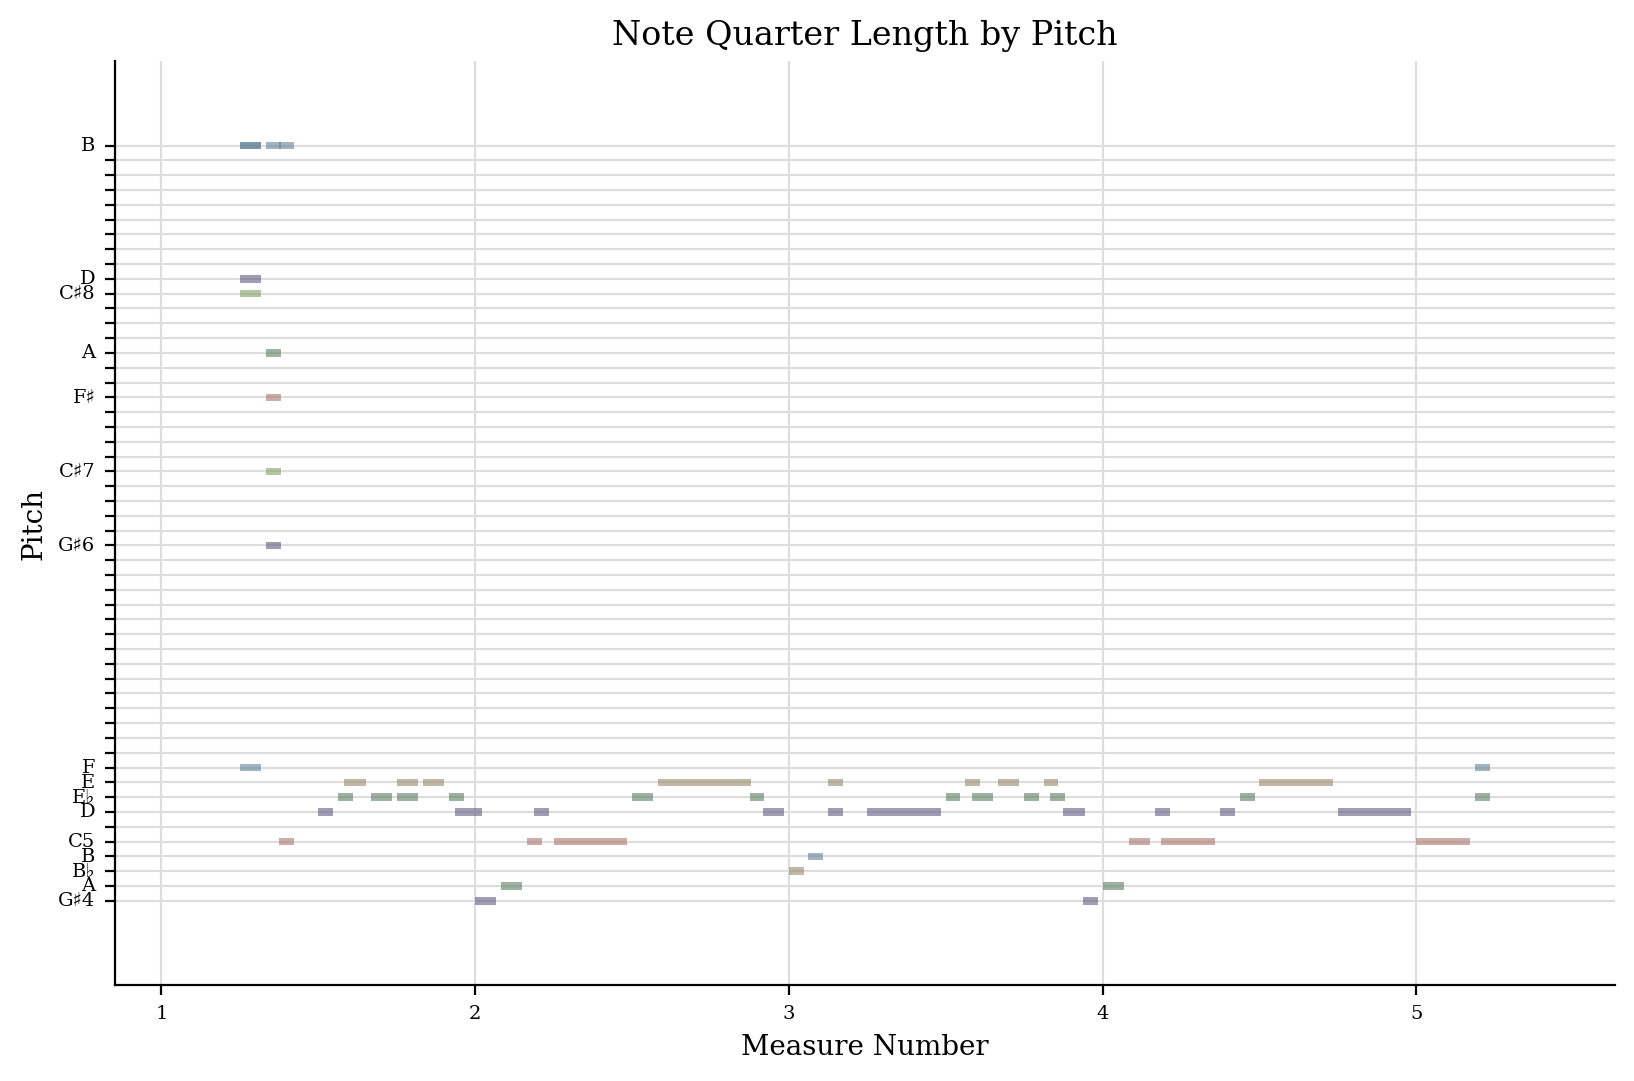

In [24]:
import music21
import matplotlib.pyplot as plt

def plot_midi(midi_file):
    # MIDI 파일을 music21 Stream 객체로 파싱
    midi_stream = music21.converter.parse(midi_file)

    # 악보 그리기
    midi_stream.plot()

# MIDI 파일 경로 설정
midi_file_path = '/content/drive/MyDrive/audio_study/test.mid'

# MIDI 파일을 악보로 플롯
plot_midi(midi_file_path)

In [27]:
from IPython.display import Audio

# MP3 파일 경로 설정
mp3_file_path = '/content/drive/MyDrive/audio_study/test.mp3'  # 여기에 실제 MP3 파일의 경로를 입력하세요.

# MP3 파일 재생
Audio(mp3_file_path)